In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.signal as signal

from pySNA import *

baseline = 274e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -2e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)

In [3]:
file_path = "/data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/6G/bio-4T_6G_30T/(黄赤血盐+K盐buffer_D91N_180mV_4T6G30T)20250708154953.dat"

# 加载数据
pySNA.load(file_path, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2026-01-07 15:47:13,212 - INFO - Successfully loaded .dat file: /data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/6G/bio-4T_6G_30T/(黄赤血盐+K盐buffer_D91N_180mV_4T6G30T)20250708154953.dat
2026-01-07 15:47:13,603 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2026-01-07 15:47:13,794 - INFO - Baseline = 33.21 pA, RMS = 58.55 pA


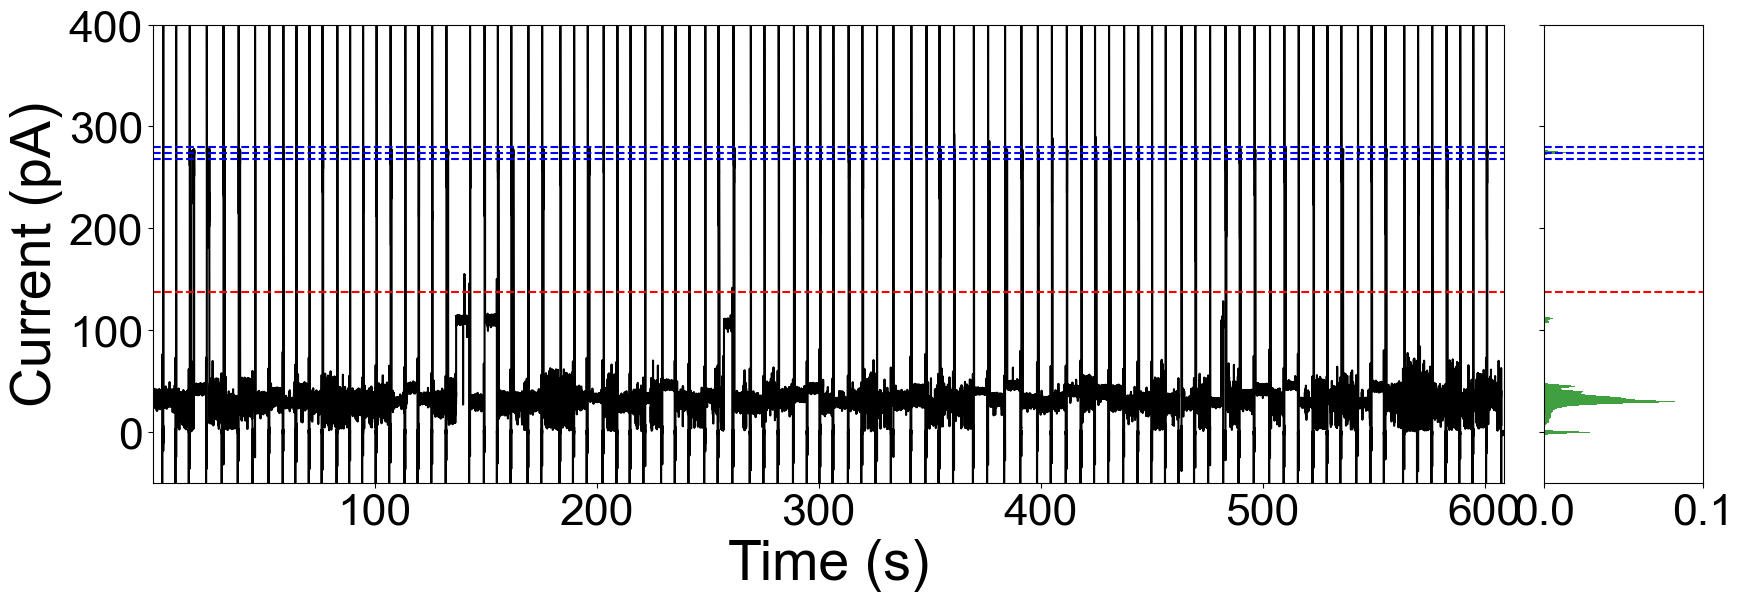

In [4]:
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [5]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 1e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]

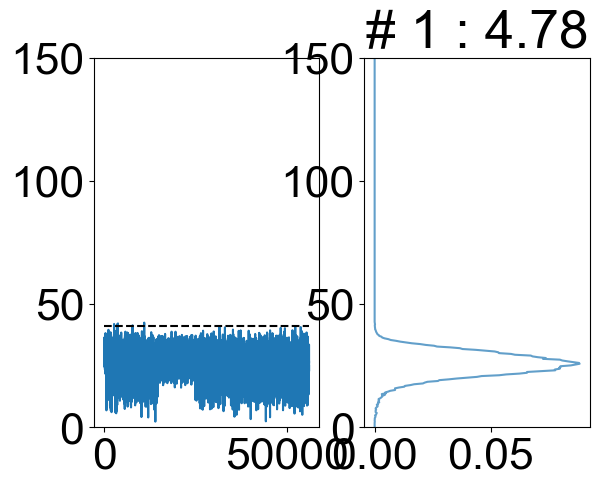

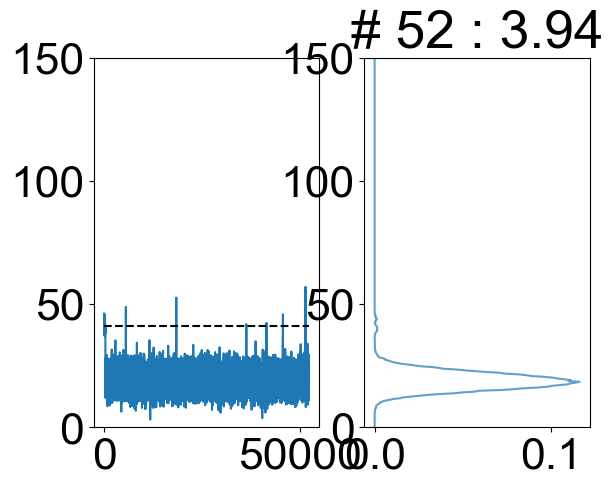

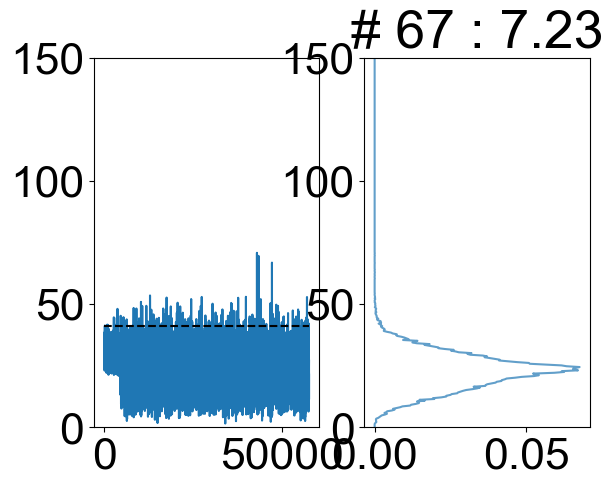

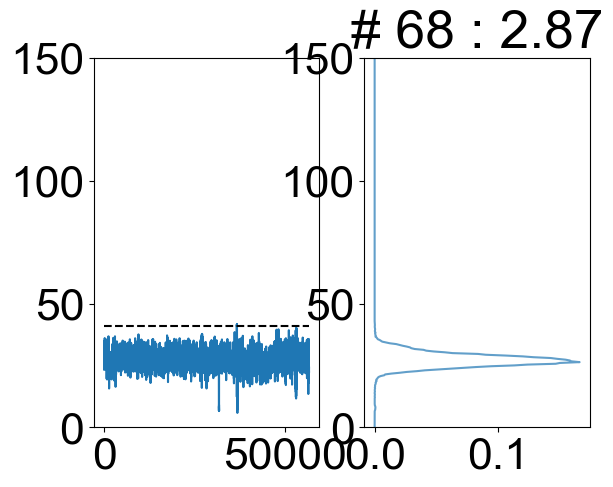

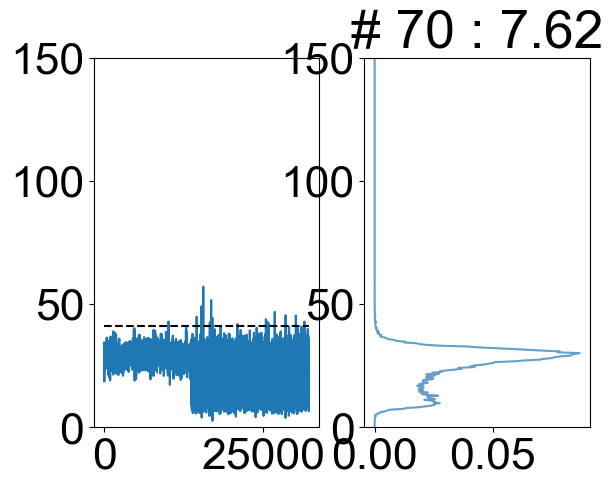

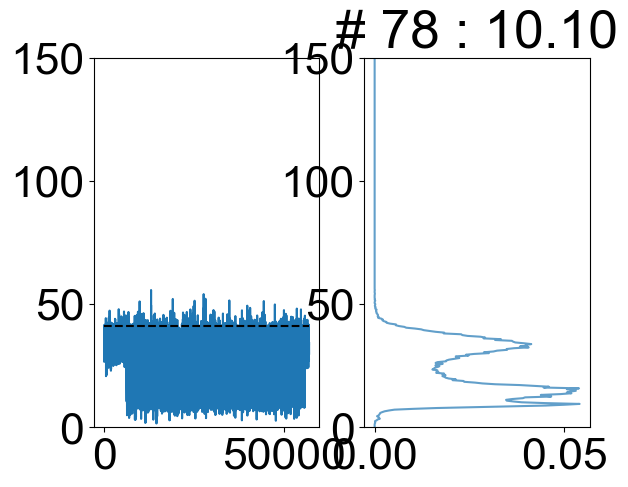

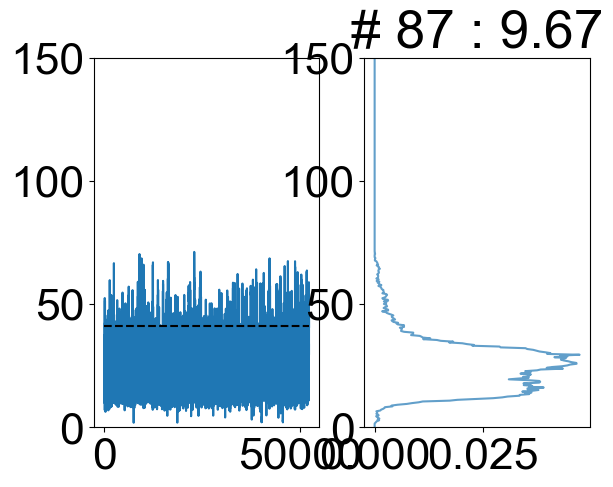

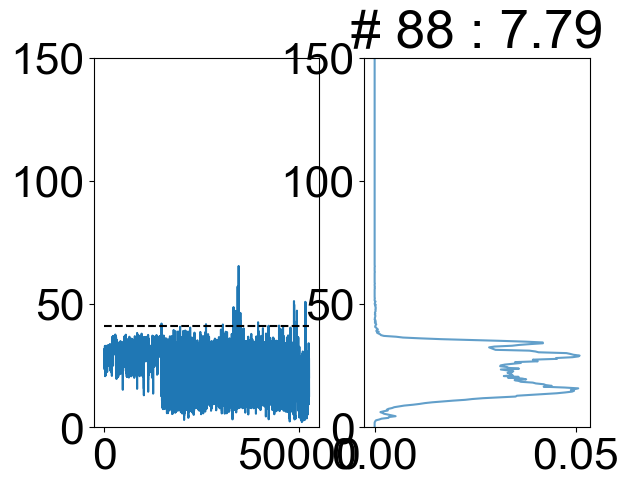

91


In [7]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]
endpoints = endpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []
temp = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    temp.append(np.median(segment))
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

(-50.0, 150.0)

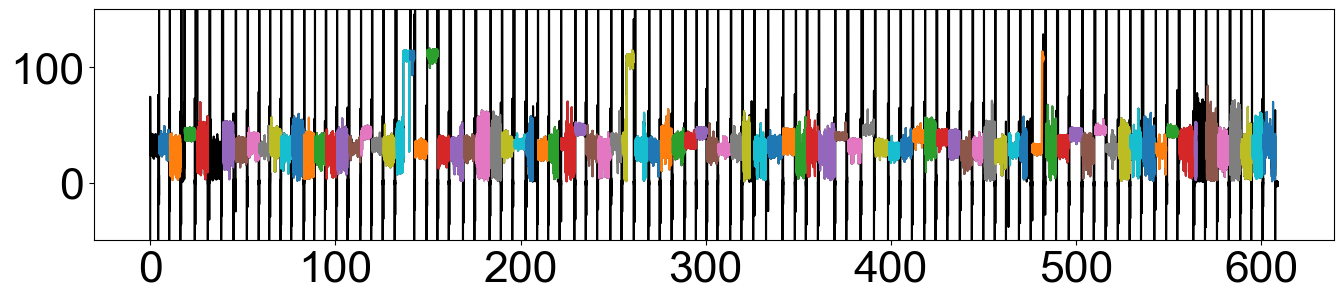

In [7]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.ylim(-50,150)

(0.0, 10.0)

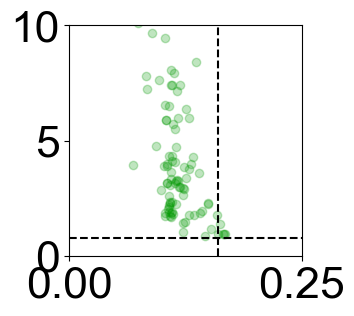

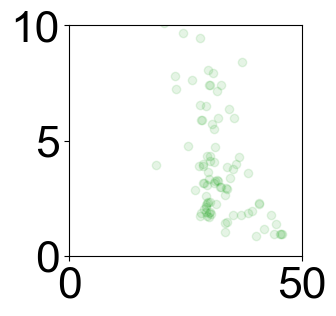

In [8]:
plt.figure(figsize=(3, 3))
plt.scatter(segment_median,segment_std,color='#009900',alpha=0.25)
plt.plot([0.1600,0.1600],[0,10],'k--')
plt.plot([0,0.25],[0.8,0.8],'k--')
plt.xlim(0,0.25)
plt.ylim(0,10)
plt.savefig('G6P4K_scatter_norm.svg',format='svg',dpi=300)
plt.figure(figsize=(3, 3))
plt.scatter(temp,segment_std,color='#009900',alpha=0.1)
plt.xlim(0,50)
plt.ylim(0,10)
#plt.savefig('G6P4K_scatter.svg',format='svg',dpi=300)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0.    ,   0.9934,   1.9868, ..., 148.0132, 149.0066, 150.    ]),
 <BarContainer object of 151 artists>)

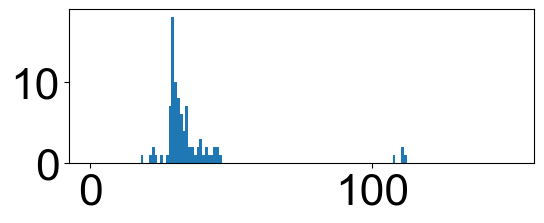

In [9]:
plt.figure(figsize=(6, 2))
plt.hist(peak_position, bins=151, density=False, range=(0, 150))

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.    , 0.005 , 0.0099, ..., 0.4901, 0.495 , 0.5   ]),
 <BarContainer object of 101 artists>)

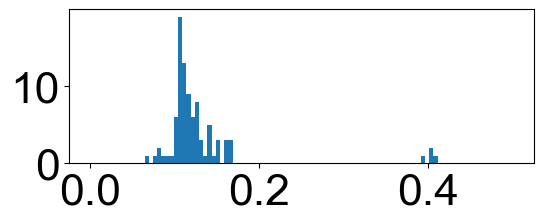

In [10]:
normalized_peak_position = [x / pySNA.baseline / 1e12 for x in peak_position]
plt.figure(figsize=(6, 2))
plt.hist(normalized_peak_position, bins=101, density=False, range=(0, 0.5))

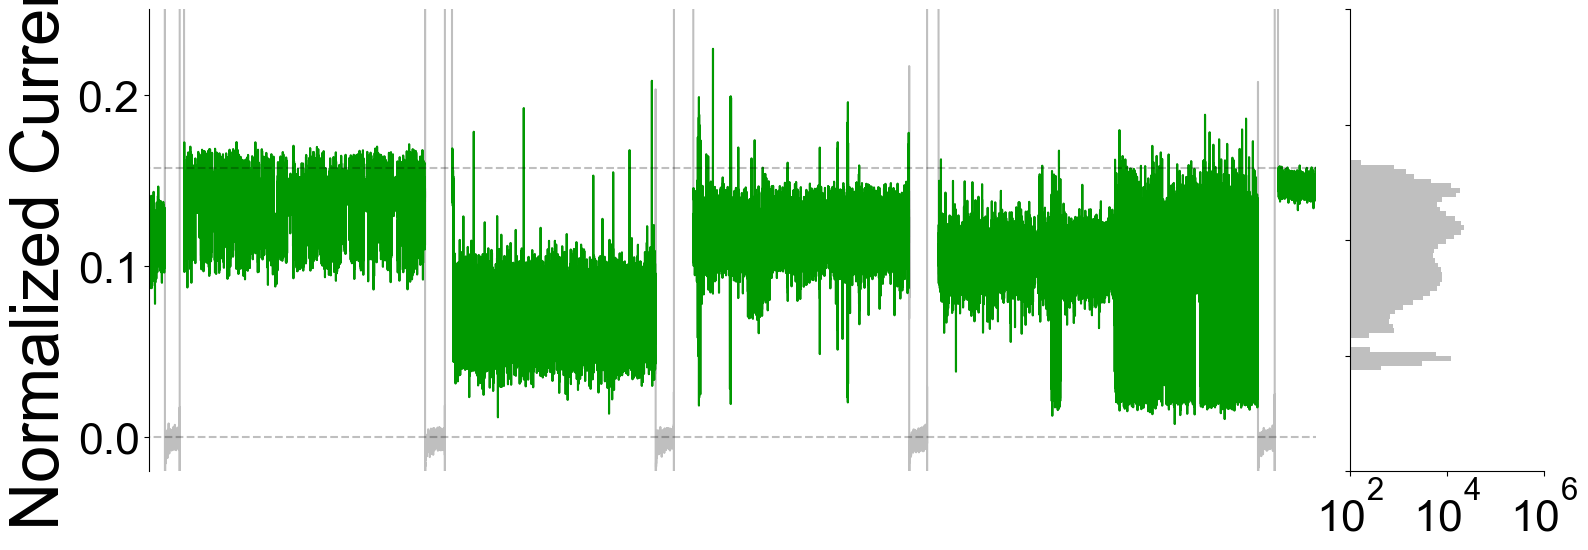

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
color = '#384879'
color = '#009900'
# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(18, 6))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]/pySNA.baseline, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]/pySNA.baseline, color=color, alpha=1)

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [1, 1], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.1570, 0.1570], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([341,371])
ax1.set_ylim([-0.02, 0.25])
ax1.set_xticks([])
#ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel("Normalized Current",fontsize=48)

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[np.int64(341*10**4):np.int64(371*10**4)]/pySNA.baseline,
                                 bins=3481, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-0.1, 0.3])
#ax2.set_yticks([0.0, 0.5, 1.0])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

plt.savefig('G6P4K_norm.svg',format='svg',dpi=300)

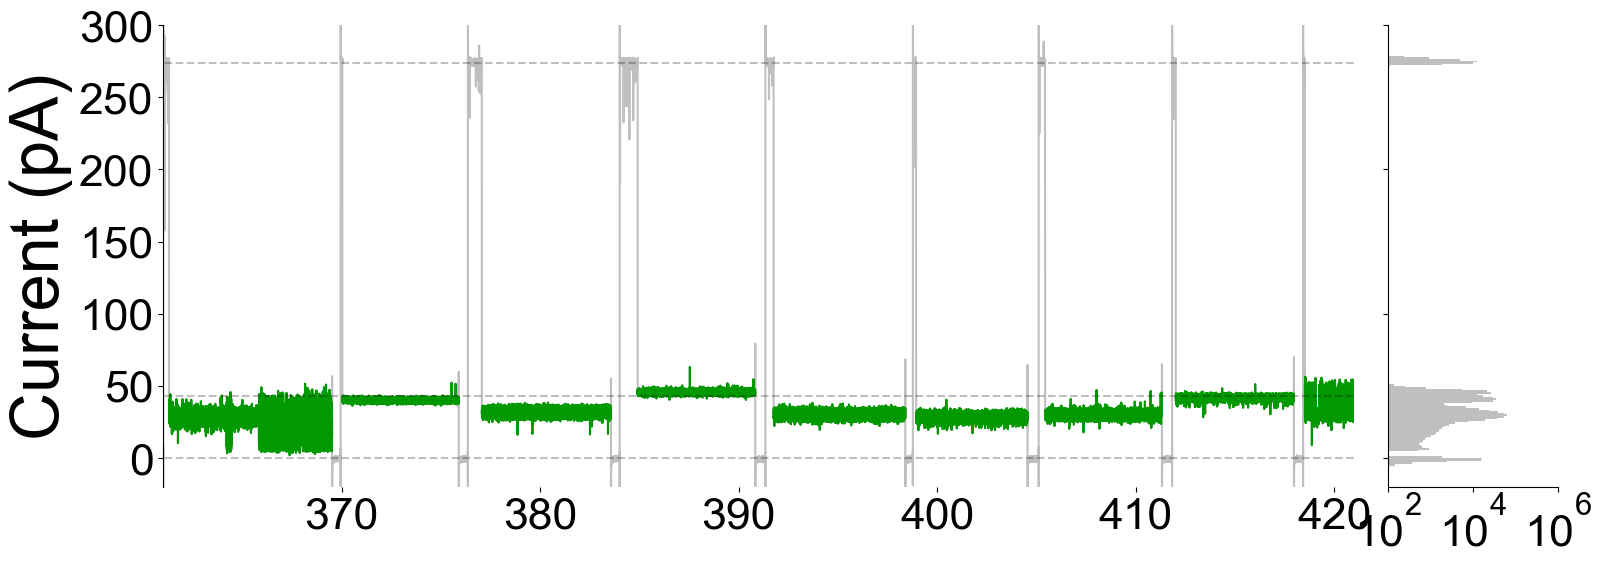

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
#color1 = '#384879'
color = '#009900'
# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(18, 6))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]*1e12, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]*1e12, color=color, alpha=1)
    

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.1570*pySNA.baseline*1e12, 0.1570*pySNA.baseline*1e12], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [pySNA.baseline*1e12, pySNA.baseline*1e12], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([361,421])
ax1.set_ylim([-20, 270])
#ax1.set_xticks([])
ax1.set_yticks([0, 50, 100, 150, 200, 250, 300])
ax1.set_ylabel("Current (pA)",fontsize=48)

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[361*10**4:421*10**4]*1e12,
                                 bins=3481, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-20, 270])
ax2.set_yticks([0, 100, 200, 300])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

plt.savefig('G6P4K.svg',format='svg',dpi=300)

In [13]:
file_path = "/data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/6G/bio-4T_6G_30T/(黄赤血盐+K盐buffer_D91N_180mV_4T6G30T)20250708154953.dat"

# 加载数据
pySNA.load(file_path, output_samplerate=10000.)#
pySNA.data = pySNA.data+offset

2026-01-07 15:48:07,899 - INFO - Successfully loaded .dat file: /data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/6G/bio-4T_6G_30T/(黄赤血盐+K盐buffer_D91N_180mV_4T6G30T)20250708154953.dat
2026-01-07 15:48:07,900 - WARNING - Already LP filtered lower than or at entry, data will not be filtered.
2026-01-07 15:48:08,370 - INFO - Baseline = 33.45 pA, RMS = 59.01 pA


[2.5252078388970514, 6.202196952992701, 2.63452883763472, 4.67788216159653, 4.266799535670378, 3.732515307582767, 2.4648134058340334, 2.239400895047405, 4.0433729052586385, 3.1392189456866495, 7.442781415729413, 4.805460701458378, 3.7177751142156286, 4.481952924747948, 3.8112330375236367, 2.4018067185068377, 2.274627367815073, 2.1713353206134705, 3.8358793841610455, 4.736409674804669, 2.5795056829496263, 3.849668846932608, 8.585490115149193, 2.985043086371579, 8.80402814266216, 7.1984453475111385, 3.5127816538020697, 1.715638801119373, 7.104347009051676, 2.330057547645207, 4.849675648119189, 8.462715499684366, 1.6614374882959269, 3.476622838724029, 4.409114973596419, 4.625036272914151, 10.615288709913294, 7.065062089371044, 2.826942230540565, 4.506464984821026, 3.290992668073904, 2.1189739989675673, 1.8750688812224223, 3.675118430610841, 2.172872549430729, 3.419960836513041, 7.130273421489468, 6.316013755301451, 3.349874842706908, 4.065551282299577, 5.338293175258719, 3.915342611476625

(-20.0, 250.0)

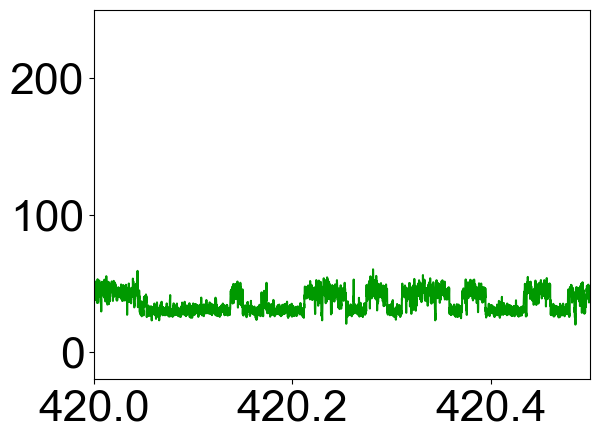

In [14]:
#plt.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]*1e12, color='k', alpha=0.25)all_filtered_data = []  # 用于存储所有符合条件的数据
all_noises = []       # 用于存储每轮数据的权重
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    #plt.plot(pySNA.data[start_idx:end_idx]*1e12)
    #pySNA.data[start_idx:end_idx]*1e12 < 70
    #plt.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]*1e12, color=color, alpha=1)
    
# 计算并过滤小于 70 的数据
    filtered_data = pySNA.data[start_idx:end_idx] * 1e12
    filtered_t = pySNA.t[start_idx:end_idx]
    
    # 只保留小于 70 的数据
    mask = filtered_data < 70
    filtered_data = filtered_data[mask]
    filtered_t = filtered_t[mask]
    plt.plot(filtered_t, filtered_data, color=color, alpha=1)
    if len(filtered_data) == 0 or np.isnan(filtered_data).any() or np.isinf(filtered_data).any():
        continue
    noise = filtered_data.std()
    all_noises.append(noise)
   

average_noise = np.mean(all_noises)
print(all_noises)
print(average_noise)


plt.xlim([420,420.5])
plt.ylim([-20, 250])

All New Data: [35.11765656077753, 25.47465936352249, 41.66990359859332, 35.063617287833246, 30.118064214906095, 28.95346134010394, 38.97545453036565, 29.892283127786087, 34.6441196069715, 29.47380325475226, 34.68560151042855, 28.639369725272985, 29.553337292818167, 28.141911262494713, 31.438886504867263, 30.759336558396686, 43.18438207305716, 33.3576086890457, 31.47561441908033, 38.929039330648585, 29.248425556019786, 31.15405564132837, 26.8518481042619, 30.275926204454546, 29.50036852699092, 30.539740490157488, 32.11492900290265, 33.47815262525773, 31.87838197644649, 28.240306710350946, 30.684888216506977, 26.919830233489638, 45.816901791633306, 32.800024834786576, 28.861624580629165, 34.744631722312405, 27.339702261317463, 27.613892470784943, 29.358928892288578, 34.18321825023986, 33.39086756527174, 34.194504802066234, 44.26670425897083, 28.85536983384097, 30.41088346652649, 32.42991030268314, 33.57788663017876, 26.76131118651261, 32.98384808355107, 37.45063246332113, 18.939289745166

(-20.0, 50.0)

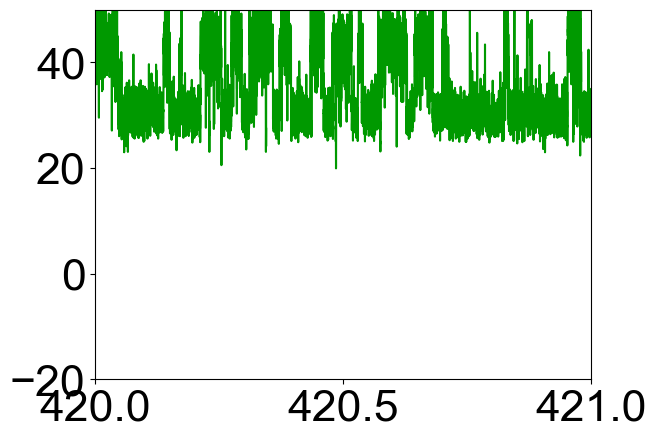

In [15]:
# 这个计算的应该是每一个事件之间的Std


all_new_data = []  # 用于存储每一轮的平均值（New_data）

for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    
    # 计算并过滤小于 70 的数据
    filtered_data = pySNA.data[start_idx:end_idx] * 1e12
    filtered_t = pySNA.t[start_idx:end_idx]
    
    # 只保留小于 70 的数据
    mask = filtered_data < 70
    filtered_data = filtered_data[mask]
    filtered_t = filtered_t[mask]
    
    # 绘制符合条件的数据
    plt.plot(filtered_t, filtered_data, color=color, alpha=1)
    
    # 跳过无效数据
    if len(filtered_data) == 0 or np.isnan(filtered_data).any() or np.isinf(filtered_data).any():
        continue
    
    # 计算每轮数据的平均值（New_data）
    new_data = filtered_data.mean()
    
    # 将每轮的平均值（New_data）添加到列表中
    all_new_data.append(new_data)

# 计算所有 New_data 的标准差
std_of_new_data = np.std(all_new_data)
print("All New Data:", all_new_data)
print("Standard Deviation of New Data:", std_of_new_data)

# 设置绘图范围
plt.xlim([420, 421])
plt.ylim([-20, 50])


All Amplitudes: [35.50476190476191, 48.838095238095235, 19.42857142857143, 65.67619047619047, 57.14285714285714, 32.91428571428571, 38.857142857142854, 46.55238095238094, 56.07619047619047, 41.75238095238095, 65.59999999999998, 60.038095238095224, 40.838095238095235, 50.81904761904762, 54.476190476190474, 32.838095238095235, 30.476190476190467, 29.638095238095236, 45.48571428571429, 61.33333333333332, 27.580952380952382, 36.72380952380953, 59.5047619047619, 41.219047619047615, 67.04761904761902, 70.32380952380952, 36.8, 27.42857142857143, 68.49523809523811, 33.142857142857146, 57.98095238095238, 70.32380952380953, 23.999999999999986, 51.42857142857142, 46.55238095238096, 56.761904761904745, 69.63809523809523, 66.89523809523807, 39.390476190476186, 57.06666666666667, 44.57142857142857, 21.333333333333336, 17.752380952380946, 45.86666666666666, 30.55238095238095, 41.219047619047615, 66.89523809523808, 57.82857142857143, 38.17142857142857, 30.933333333333334, 65.29523809523808, 59.0476190

(-20.0, 50.0)

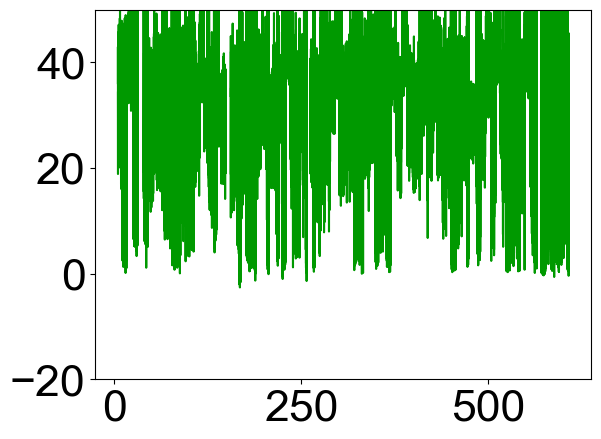

In [16]:
all_amplitudes = []  # 用于存储每一轮的摆幅（Amplitude）

for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    
    # 计算并过滤小于 70 的数据
    filtered_data = pySNA.data[start_idx:end_idx] * 1e12
    filtered_t = pySNA.t[start_idx:end_idx]
    
    # 只保留小于 70 的数据
    mask = filtered_data < 70
    filtered_data = filtered_data[mask]
    filtered_t = filtered_t[mask]
    
    # 绘制符合条件的数据
    plt.plot(filtered_t, filtered_data, color=color, alpha=1)
    
    # 跳过无效数据
    if len(filtered_data) == 0 or np.isnan(filtered_data).any() or np.isinf(filtered_data).any():
        continue
    
    # 计算该数据段的摆幅（Amplitude）
    amplitude = filtered_data.max() - filtered_data.min()
    
    # 将每轮的摆幅添加到列表中
    all_amplitudes.append(amplitude)

# 计算所有摆幅的平均值（Mean Swing）
mean_swing = np.mean(all_amplitudes)
print("All Amplitudes:", all_amplitudes)
print("Mean Swing (Average Amplitude):", mean_swing)

# 设置绘图范围
#plt.xlim([420, 421])
plt.ylim([-20, 50])


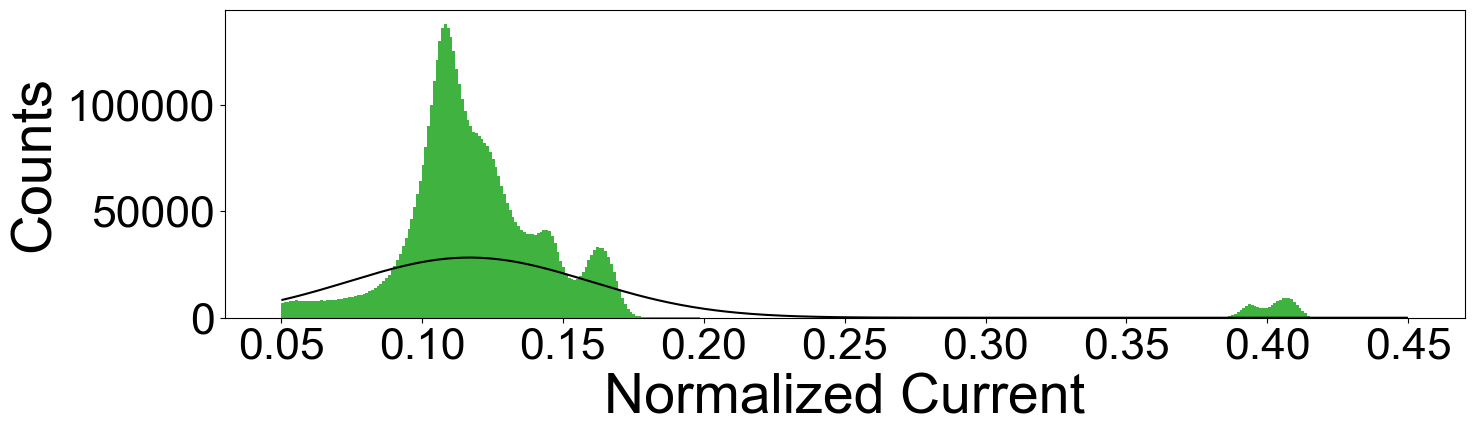

Peak 1: Amplitude = 0.01, Center = 0.1800, Sigma = 0.0000
Peak 2: Amplitude = 0.28, Center = 0.1169, Sigma = 0.0426


In [12]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.05,0.45),
                                 color=color, alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数
num_peaks = 2
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.15,0.18,0.16,0.18], peak_amp = [1.1e5,1.4e5,0.8e5,0.8e5], peak_sigma = [2e-3,2e-3,2e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [np.inf, 0.45, np.inf] * num_peaks  # 上界

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")

# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

In [ ]:
np.savez("G6P5K.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)